## Crypto Predictor Dashboard

In [ ]:
import time
import pymysql
import requests
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
from fbprophet import Prophet
from sklearn.linear_model import LinearRegression

In [ ]:
#Alternative.me API - Fear and Greed Index
API_KEY = "https://api.alternative.me/fng"
url = "https://api.alternative.me/fng/?limit=30&date_format=world/search?key="+API_KEY
response = requests.get(url)
indexData = response.json()
time.sleep(1)
indexData

In [ ]:
#Last 30 days Average Value - Fear and Greed Index 

df = pd.DataFrame(columns=["index_date","index_value"])

for index in indexData['data']:
    index_date = index['timestamp']
    index_value = index['value']
    df = df.append({'index_date':index_date,'index_value':index_value},ignore_index=True)

df['index_value'] = df['index_value'].astype(int)
df['index_date'] = pd.to_datetime(df['index_date'],format="%d-%m-%Y").dt.strftime('%d-%m-%Y')
df['index_date'] = pd.to_datetime(df['index_date'],format="%d-%m-%Y")
df['index_date'] = pd.to_datetime(df['index_date'],dayfirst=True)

print(df)
print(df.dtypes)
print("Last 30 Days Average: ",df["index_value"].mean())

In [ ]:
#PyTrend API - Unofficial Google Trend API

pytrend = TrendReq()

#Last 30 days Average Value - Bitcoin Google Trend Search

kw_list=["Bitcoin"]
pytrend.build_payload(kw_list,cat=0,timeframe='today 1-m',geo='', gprop='')

google_btc_data = pytrend.interest_over_time()
df2 = pd.DataFrame(google_btc_data)
df2.reset_index(inplace=True)
df2['Bitcoin'] = df2['Bitcoin'].astype(int)
df2 = df2.drop(labels='isPartial', axis=1)
df2 = df2.rename(columns={'date': 'gdate','Bitcoin': 'gvalue'})

print(df2)
print(df2.dtypes)
print("Last 30 Days Average: ",df2["gvalue"].mean())

        gdate  gvalue
0  2022-02-17      50
1  2022-02-18      51
2  2022-02-19      45
3  2022-02-20      51
4  2022-02-21      55
5  2022-02-22      62
6  2022-02-23      52
7  2022-02-24     100
8  2022-02-25      68
9  2022-02-26      52
10 2022-02-27      53
11 2022-02-28      65
12 2022-03-01      72
13 2022-03-02      63
14 2022-03-03      56
15 2022-03-04      55
16 2022-03-05      47
17 2022-03-06      46
18 2022-03-07      54
19 2022-03-08      52
20 2022-03-09      59
21 2022-03-10      54
22 2022-03-11      48
23 2022-03-12      42
24 2022-03-13      41
25 2022-03-14      45
26 2022-03-15       0
gdate     datetime64[ns]
gvalue             int64
dtype: object
Last 30 Days Average:  53.25925925925926


In [ ]:
#AWS - RDS Connection

connection = pymysql.connect(host='',
                             user='',
                             password='',
                             database='',
                             charset='',
                             cursorclass=pymysql.cursors.DictCursor)

curr = connection.cursor()

In [ ]:
#Create MySQL Tables for API 1 

def create_table(curr):
  create_table_command = ("""CREATE TABLE IF NOT EXISTS Indexfng
  (
  index_date date primary key,
  index_value integer(2)
  );""")
  curr.execute(create_table_command)

#Insert into db tables
def insert_into_table(curr, index_date, index_value):
    insert_into = ("""INSERT INTO Indexfng (index_date, index_value)
    VALUES(%s,%s);
    """)
    row_to_insert = (index_date, index_value)
    curr.execute(insert_into, row_to_insert)

def append_from_df_to_db(curr,df):
    for i, row in df.iterrows():
        insert_into_table(curr, row['index_date'], row['index_value'])

In [ ]:
#Create MySQL Tables for API 2

def create_table2(curr):
  create_table_command2 = ("""CREATE TABLE IF NOT EXISTS Gtrend
  (
  gdate date primary key,
  gvalue integer(2)
  );""")
  curr.execute(create_table_command2)

#Insert into db tables
def insert_into_table2(curr, gdate, gvalue):
    insert_into2 = ("""INSERT INTO Gtrend (gdate, gvalue)
    VALUES(%s,%s);
    """)
    row_to_insert2 = (gdate, gvalue)
    curr.execute(insert_into2, row_to_insert2)

def append_from_df_to_db2(curr,df2):
    for ii, roww in df2.iterrows():
        insert_into_table2(curr, roww['gdate'], roww['gvalue'])


In [ ]:
#Ignore - Testing Purpose

curr.execute("TRUNCATE TABLE Indexfng")
curr.execute("TRUNCATE TABLE Gtrend")

In [ ]:
create_table(curr)

append_from_df_to_db(curr, df)
connection.commit()

curr.execute("SELECT * FROM Indexfng;")
print(curr.fetchall())

In [ ]:
create_table2(curr)

append_from_df_to_db2(curr, df2)
connection.commit()

curr.execute("SELECT * FROM Gtrend;")
print(curr.fetchall())

Text(0.5, 0, 'Date')

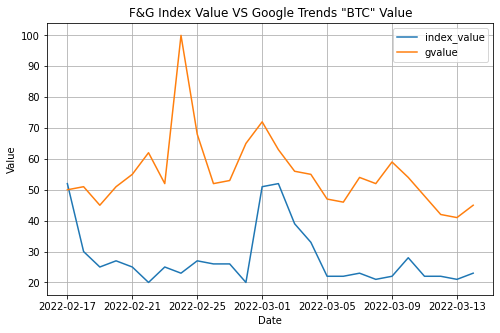

In [ ]:
#SQL Query

query = curr.execute("""SELECT index_date AS date, index_value, Gtrend.gvalue FROM Indexfng
LEFT JOIN Gtrend
ON index_date = Gtrend.gdate
WHERE Gtrend.gvalue IS NOT NULL AND Gtrend.gvalue != 0""")

query_df = pd.DataFrame(curr.fetchall())
x = query_df.set_index('date').plot(title='F&G Index Value VS Google Trends "BTC" Value',grid=True,figsize=(8, 5))
x.set_ylabel('Value')
x.set_xlabel('Date')

[*********************100%***********************]  1 of 1 completed


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


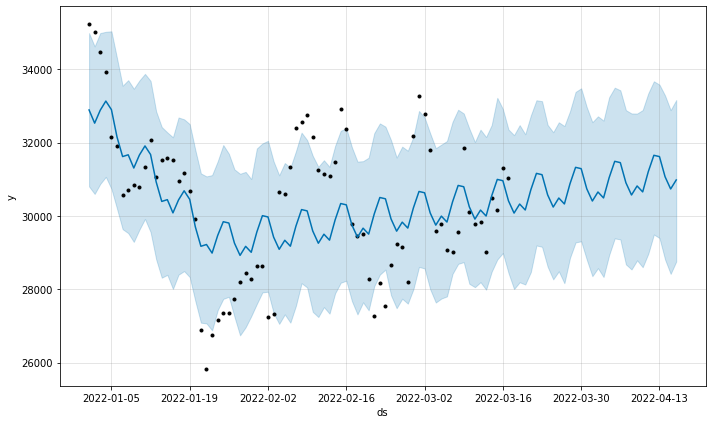

In [ ]:
#yfinance API - Unofficial Yahoo Finance API

#BTC-GBP Future Prediction Using Time Series Analysis

df3 = yf.download('BTC-GBP', period = "ytd")
df3.reset_index(inplace = True)
df3 = df3[['Date','Adj Close']]
df3.columns = ['ds','y']

model = Prophet()
model.fit(df3)
future_dates = model.make_future_dataframe(periods =30)
prediction = model.predict(future_dates)
fig = model.plot(prediction)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


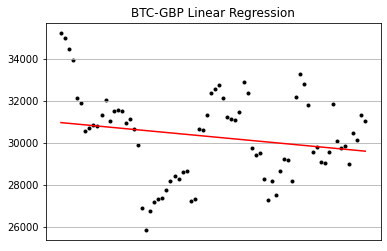

In [ ]:
#BTC-GBP Future Prediction Using Linear Regression

df3['ds'] = pd.to_datetime(df3['ds'])
df3['ds']= df3['ds'].map(dt.datetime.toordinal)

btcx = df3[['ds']]
btcy = df3[['y']]

regressor = LinearRegression()
regressor.fit(btcx, btcy)

y_pred = regressor.predict(btcx)
plt.scatter(btcx, btcy,marker='.',color = 'black')
plt.plot(btcx, regressor.predict(btcx), color = 'r')
plt.title("BTC-GBP Linear Regression")
plt.xticks([])
plt.grid()
plt.show()

[*********************100%***********************]  1 of 1 completed

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


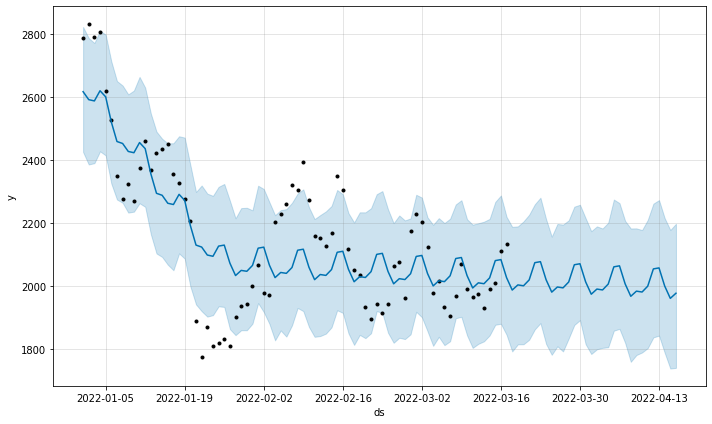

In [ ]:
#ETH-GBP Future Prediction Using Time Series Analysis

df4 = yf.download('ETH-GBP', period = "ytd")
df4.reset_index(inplace = True)
df4 = df4[['Date','Adj Close']]
df4.columns = ['ds','y']

model2 = Prophet()
model2.fit(df4)
future_dates = model2.make_future_dataframe(periods =30)
prediction = model2.predict(future_dates)
fig2 = model2.plot(prediction)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


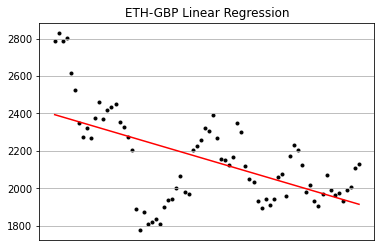

In [ ]:
#ETH-GBP Future Prediction Using Linear Regression

df4['ds'] = pd.to_datetime(df4['ds'])
df4['ds']= df4['ds'].map(dt.datetime.toordinal)

ethx = df4[['ds']]
ethy = df4[['y']]

regressor.fit(ethx, ethy)
y2_pred = regressor.predict(ethx)

plt.scatter(ethx, ethy, marker='.',color = 'black')
plt.plot(ethx, regressor.predict(ethx), color = 'r')
plt.title("ETH-GBP Linear Regression")
plt.xticks([])
plt.grid()
plt.show()